# on Amazon Fine FOod Reviews

In [1]:
#importing necessary packages
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import sqlite3
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import pickle
import sklearn.cross_validation
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.metrics import precision_score,recall_score,f1_score,confusion_matrix,roc_auc_score,roc_curve


C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Reading already Cleaned, Preprocessed data from database

After removing stopwords, punctuations, meaningless characters, HTML tags from Text 
and done stemming. Using it directly as it was alredy done in prevoius assignment

In [2]:
#Reading
conn= sqlite3.connect('cleanedTextData.sqlite')
data= pd.read_sql_query('''
SELECT * FROM Reviews
''',conn)
data=data.drop('index',axis=1)
data.shape

(364171, 11)

In [3]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'CleanedText'],
      dtype='object')

In [4]:
data['CleanedText'].head(3)

0    witti littl book make son laugh loud recit car...
1    rememb see show air televis year ago child sis...
2    beetlejuic well written movi everyth act speci...
Name: CleanedText, dtype: object

 ## Sorting on the basis of 'Time' and taking top 100k pts

 This data has time attribute so it will be reasonable to do time based splitting instead
   of random splitting.

 So, before splitting we have to sort our data according to time and here we are taking
 100k points from our dataset(population)

In [5]:
data["Time"] = pd.to_datetime(data["Time"], unit = "ms")
data = data.sort_values(by = "Time")

In [6]:
#latest 100k points according to time
data= data[:100000]
len(data)

100000

## Splitting data into train70% test30%

Splitting our data into train and test data.
* train data will train our ML model
* cross validataion data will be for determining our hyperparameter
* test data will tell how Generalized our model is
* dataframes after splitting:- traindata, testdata

In [7]:
traindata, testdata= train_test_split(data, test_size= 0.3, shuffle= False,stratify= None)
print(len(traindata),len(testdata))

70000 30000


In [8]:
Xtrain,Xtest= traindata['CleanedText'],testdata['CleanedText']
Ytrain,Ytest= traindata['Score'],testdata['Score']

In [9]:
# converting positive to 1 and negative to 0
Ytrain=Ytrain.map(lambda x:1 if x=='Positive' else 0)
Ytest=Ytest.map(lambda x:1 if x=='Positive' else 0)

Taking Text and score(class) as sequences
* traindata -> Xtrain, Ytrain
* testdata -> Xtest, Ytest

# SelfDefined Functions

Three functions are defined below:-
* GridCvDt(xtrain) . . does gridsearchCV on RandomForestClassifier returns tuned Hyperparameters
* Randomforest() . . apply RandomForestClassifier with tuned Hyperparameters
* GridCvGBDT() . . does gridsearchCV on GBDTClassifier returns tuned Hyperparameters
* GBDTclassif() . . apply GBDTClassifier with tuned Hyperparameters
* GridCvresult() . . Shows GridCV results in form of heatmap
* show_most_informative_features() . . prints wordcloud of top 20 features of model

### RandomForest Functions based on sklearn

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import scikitplot.plotters as skplt

def GridCvDt(xtrain):
    '''
    Gridsearch crossvalidation (on Depth and n_estimators) on given data using randomForest model
    Uses roc_auc as scoring metric
    '''
    RFCLF= RandomForestClassifier(criterion='gini',min_samples_split=1500,class_weight='balanced',n_jobs=-1)
    parameters= {'max_depth': [8,12,16,20,24,28], 'n_estimators': [10,25,40,55,70,85]}
    GSC= GridSearchCV(RFCLF, parameters, scoring= 'roc_auc', n_jobs= -1,cv=5)
    GSC.fit(xtrain,Ytrain)
    
    n_estimators = GSC.best_params_['n_estimators']
    max_depth = GSC.best_params_['max_depth']

    #best outcome
    print('\n',GSC.best_estimator_)
    print('Best Hyperparameter is ',GSC.best_params_)
    print('Best auc score is ',GSC.best_score_)
    
    #return
    return (max_depth,n_estimators,GSC)

def Randomforest(depth,estimators,xtrn,xtst):    
    '''
    Apply RandomforestClasifier on train data and get performance of model using different metrics
    '''
    #Testing performance on Test data
    clf= RandomForestClassifier(criterion='gini', max_depth= depth, n_estimators= estimators,\
                                min_samples_split=1500,class_weight='balanced',n_jobs=-1)
    clf.fit(xtrn,Ytrain)
    y_train_pred= clf.predict(xtrn)
    y_pred = clf.predict(xtst)
    y_pred_proba= clf.predict_proba(xtst)[:,1]
    #Printing Different scores
    print("AUC score on test set: %0.3f%%"%(roc_auc_score(Ytest, y_pred_proba)*100))
    print("Accuracy on test set: %0.3f%%"%(accuracy_score(Ytest, y_pred)*100))
    print("Precision on test set: %0.3f"%(precision_score(Ytest, y_pred)*100))
    print("Recall on test set: %0.3f"%(recall_score(Ytest, y_pred)*100))
    print("F1-Score on test set: %0.3f"%(f1_score(Ytest, y_pred)*100))
    #ROC curve

    skplt.plot_roc_curve(Ytest, clf.predict_proba(xtst),curves=('macro'),title='Test ROC')
    skplt.plot_roc_curve(Ytrain, clf.predict_proba(xtrn),curves=('macro'),title='Train ROC')
    plt.show()
    #Confusion Matrix
    plt.figure(2)
    skplt.plot_confusion_matrix(Ytest, y_pred, normalize=True)
    
    return clf


### GBDT functions based on xgboost

In [64]:
from xgboost import XGBClassifier
def GridCvGBDT(xtrain):
    '''
    Gridsearch crossvalidation (on Depth and n_estimators) on given data using GBDT trees model
    Uses roc_auc as scoring metric
    '''
    GBDTCLF= XGBClassifier(criterion='gini',scale_pos_weight=0.125,subsample=0.2,n_jobs=-1)
    parameters= {'max_depth': [8,12,16,20,24,28], 'n_estimators': [10,25,40,55,70,85]}
    GSC= GridSearchCV(GBDTCLF, parameters, scoring= 'roc_auc', n_jobs= -1,cv=5)
    GSC.fit(xtrain,Ytrain)
    
    #plotting
    n_estimators = GSC.best_params_['n_estimators']
    max_depth = GSC.best_params_['max_depth']

    #best outcome
    print('\n',GSC.best_estimator_)
    print('Best Hyperparameter is ',GSC.best_params_)
    print('Best auc score is ',GSC.best_score_)
    
    #return
    return (max_depth,n_estimators,GSC)

def GBDTclassif(depth,estimators,xtrn,xtst):    
    '''
    Apply GBDTclassifier on train data and get performance of model using different metrics
    '''
    #Testing performance on Test data
    clf= XGBClassifier(criterion='gini',scale_pos_weight=0.125,subsample=0.2,n_jobs=-1\
                          ,max_depth=depth,n_estimators=estimators)

    clf.fit(xtrn,Ytrain)
    y_train_pred= clf.predict(xtrn)
    y_pred = clf.predict(xtst)
    y_pred_proba= clf.predict_proba(xtst)[:,1]
    #Printing Different scores
    print("AUC score on test set: %0.3f%%"%(roc_auc_score(Ytest, y_pred_proba)*100))
    print("Accuracy on test set: %0.3f%%"%(accuracy_score(Ytest, y_pred)*100))
    print("Precision on test set: %0.3f"%(precision_score(Ytest, y_pred)*100))
    print("Recall on test set: %0.3f"%(recall_score(Ytest, y_pred)*100))
    print("F1-Score on test set: %0.3f"%(f1_score(Ytest, y_pred)*100))
    #ROC curve
    plt.figure(1)
    skplt.plot_roc_curve(Ytest, clf.predict_proba(xtst),curves=('macro'),title='Test ROC')
    skplt.plot_roc_curve(Ytrain, clf.predict_proba(xtrn),curves=('macro'),title='Train ROC')

    plt.show()
    #Confusion matrics
    plt.figure(2)
    skplt.plot_confusion_matrix(Ytest, y_pred, normalize=True)
    
    return clf


### Showing GridCV results

In [35]:
def GridCvresult(GSC):
    '''
    returns heatmap of train and test score during gridCV
    '''
    keys=['param_max_depth','param_n_estimators','mean_train_score','mean_test_score']
    dic = {x:GSC.cv_results_[x] for x in keys}
    res= pd.DataFrame(dic)
    res1= res.sort_values('mean_train_score').copy()
    res2= res.sort_values('mean_test_score').copy()
    print('Showing Gridcv results')
    #heatmap trn
    plt.figure(1)
    res1 = res1.pivot("param_max_depth", "param_n_estimators", "mean_train_score")
    ax1 = sns.heatmap(res1, annot=True, linewidths=.5)
    ax1.set_title('Train score For different parameters:-')
    
    #heatmap cv
    plt.figure(2)
    res2 = res2.pivot("param_max_depth", "param_n_estimators", "mean_test_score")
    ax2 = sns.heatmap(res1, annot=True, linewidths=.5)
    ax2.set_title('Test score For different parameters:-')

### Showing important features using Wordcloud

In [36]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
def show_most_informative_features(vectorizer, clf, n=20):
    '''
    prints wordcloud of top n features from the model
    '''
    feat =  clf.feature_importances_
    # Sort feature feat in descending order
    feat_slice = np.argsort(feat)[::-1][:n]
    all_feat = vectorizer.get_feature_names()
    all_feat = np.array(all_feat)
    b = all_feat[feat_slice]

    wc = WordCloud(background_color="white")
    wc.generate(str(b))
    print("Word Cloud:")
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

---
# BOW Vectorization------------------------------------------------------------
Bow vectorization is basic technique to convert a text into numerical vector.
* We will build a model on train text using fit-transform
* Then transform (test) text on model build by train text
* Transformed data will be in the form of sparse matrix

In [15]:
# vectorizing X and transforming
bowModel=CountVectorizer()
XtrainBOWV=bowModel.fit_transform(Xtrain.values)

In [16]:
XtestBOWV= bowModel.transform(Xtest)
XtestBOWV.shape

(30000, 39730)

## RamdomForest

In [17]:
#gridsearchCv
max_depth,n_estimators,GSC11= GridCvDt(XtrainBOWV)


 RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=28, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=1500, min_weight_fraction_leaf=0.0,
            n_estimators=85, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Best Hyperparameter is  {'max_depth': 28, 'n_estimators': 85}
Best auc score is  0.9050643670187561


Showing Gridcv results


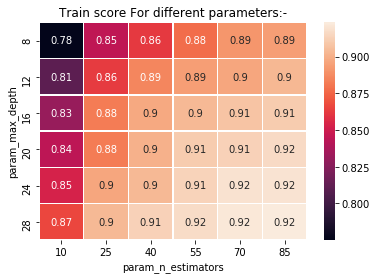

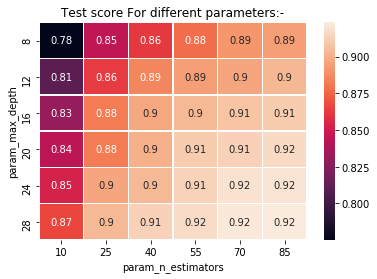

In [65]:
GridCvresult(GSC11)

AUC score on test set: 90.944%
Accuracy on test set: 84.747%
Precision on test set: 96.535
Recall on test set: 85.399
F1-Score on test set: 90.626


C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_roc_curve instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_roc_curve instead.
  warnings.warn(msg, category=DeprecationWarning)


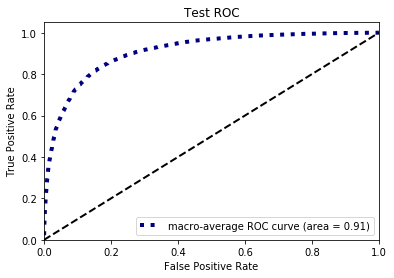

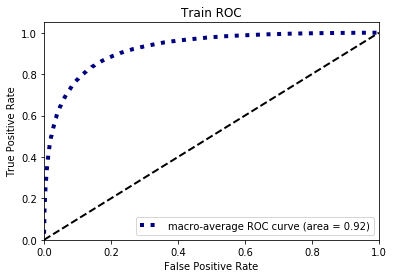

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<Figure size 432x288 with 0 Axes>

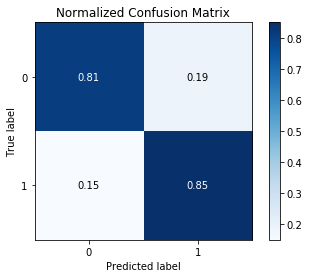

In [66]:
#performance of model on tuned hyperparamters with test data
clf11=Randomforest(max_depth,n_estimators,XtrainBOWV,XtestBOWV)

#### Feature importance using wordcloud

Word Cloud:


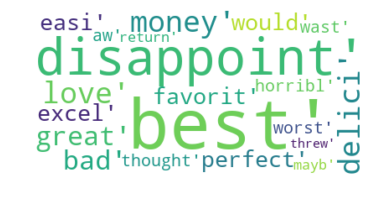

In [67]:
show_most_informative_features(bowModel, clf11, n=20)

## GBDTClassifier

In [68]:
#gridsearchCv
max_depth,n_estimators,GSC12= GridCvGBDT(XtrainBOWV)


 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, criterion='gini', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=28, min_child_weight=1, missing=None,
       n_estimators=85, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=0.125, seed=None, silent=True,
       subsample=0.2)
Best Hyperparameter is  {'max_depth': 28, 'n_estimators': 85}
Best auc score is  0.9036776938340878


Showing Gridcv results


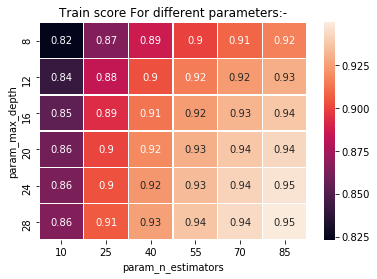

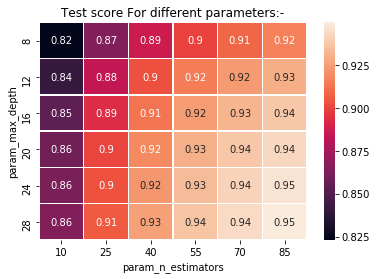

In [69]:
GridCvresult(GSC12)

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


AUC score on test set: 91.174%
Accuracy on test set: 85.340%
Precision on test set: 96.389
Recall on test set: 86.252
F1-Score on test set: 91.039


C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_roc_curve instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_roc_curve instead.
  warnings.warn(msg, category=DeprecationWarning)


<Figure size 432x288 with 0 Axes>

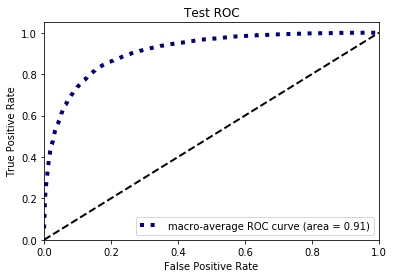

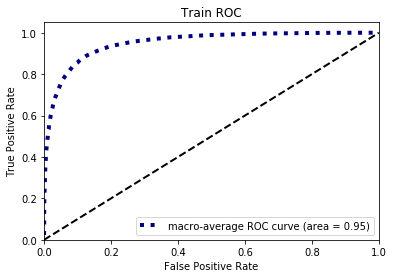

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<Figure size 432x288 with 0 Axes>

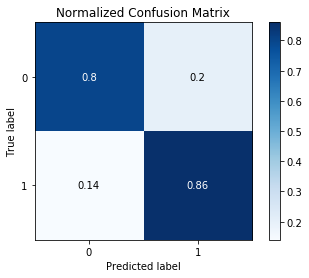

In [70]:
#performance of model on tuned hyperparamters with test data
clf12=GBDTclassif(max_depth,n_estimators,XtrainBOWV,XtestBOWV)

#### Feature importance using wordcloud

Word Cloud:


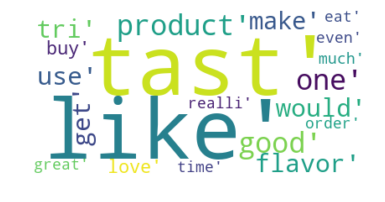

In [71]:
show_most_informative_features(bowModel, clf12, n=20)

***
# TFIDF vectorization-----------------------------------------------------------

* We will build a model on train text using fit-transform
* Then transform (test) text on model build by train text
* Transformed data will be in the form of sparse matrix

In [72]:
# generating vetor out of text using tfidf
tfidfModel=TfidfVectorizer()
XtrainTFIDFV= tfidfModel.fit_transform(Xtrain)
XtestTFIDFV= tfidfModel.transform(Xtest)

## RamdomForest

In [73]:
#gridsearchCv
max_depth,n_estimators,GSC21= GridCvDt(XtrainTFIDFV)


 RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=28, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=1500, min_weight_fraction_leaf=0.0,
            n_estimators=85, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Best Hyperparameter is  {'max_depth': 28, 'n_estimators': 85}
Best auc score is  0.901841796536101


Showing Gridcv results


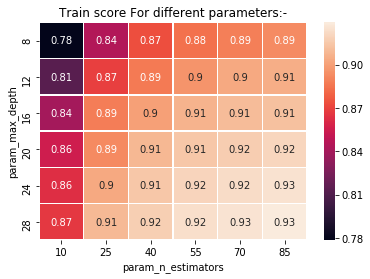

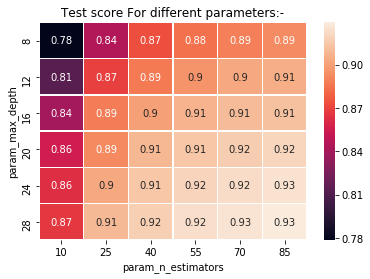

In [74]:
GridCvresult(GSC21)

AUC score on test set: 90.725%
Accuracy on test set: 84.770%
Precision on test set: 96.298
Recall on test set: 85.654
F1-Score on test set: 90.664


C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_roc_curve instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_roc_curve instead.
  warnings.warn(msg, category=DeprecationWarning)


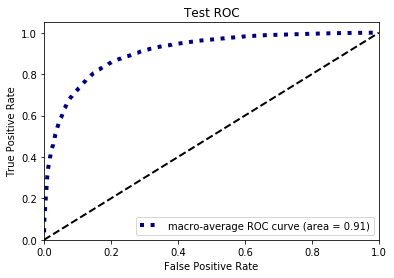

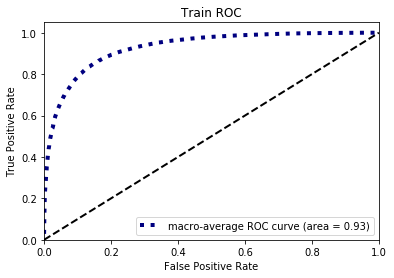

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<Figure size 432x288 with 0 Axes>

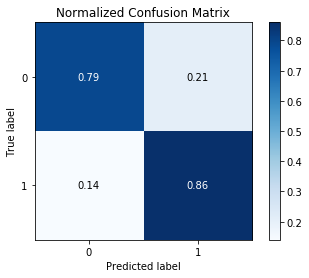

In [75]:
#performance of model on tuned hyperparamters with test data
clf21= Randomforest(max_depth,n_estimators,XtrainTFIDFV,XtestTFIDFV)

#### Feature importance using wordcloud

Word Cloud:


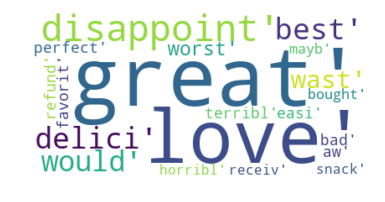

In [76]:
show_most_informative_features(tfidfModel, clf21, n=20)

## GBDTClassifier

In [77]:
#gridsearchCv
max_depth,n_estimators,GSC22= GridCvGBDT(XtrainTFIDFV)


 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, criterion='gini', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=28, min_child_weight=1, missing=None,
       n_estimators=85, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=0.125, seed=None, silent=True,
       subsample=0.2)
Best Hyperparameter is  {'max_depth': 28, 'n_estimators': 85}
Best auc score is  0.8984762733008449


Showing Gridcv results


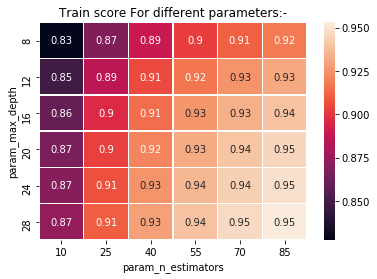

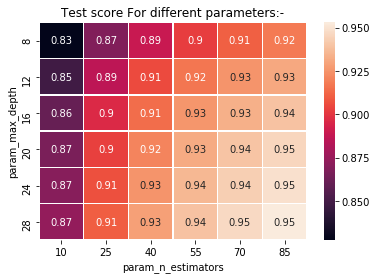

In [78]:
GridCvresult(GSC22)

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


AUC score on test set: 90.698%
Accuracy on test set: 85.627%
Precision on test set: 95.967
Recall on test set: 87.009
F1-Score on test set: 91.269


C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_roc_curve instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_roc_curve instead.
  warnings.warn(msg, category=DeprecationWarning)


<Figure size 432x288 with 0 Axes>

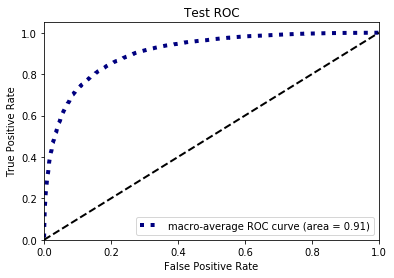

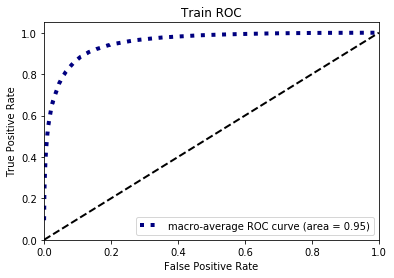

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<Figure size 432x288 with 0 Axes>

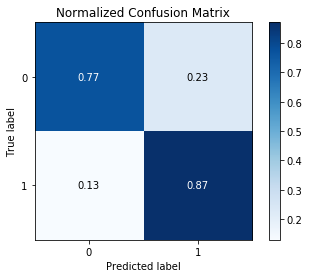

In [79]:
#performance of model on tuned hyperparamters with test data
clf22=GBDTclassif(max_depth,n_estimators,XtrainTFIDFV,XtestTFIDFV)

#### Feature importance using wordcloud

Word Cloud:


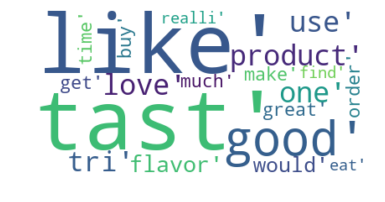

In [80]:
show_most_informative_features(tfidfModel, clf22, n=20)

# Avg W2V vectorization-------------------------------------------------------

In [81]:
import gensim
# training our gensim model on our train text
import re
import string
def cleanhtml(sentance): #substitute expression contained in <> with ' '
    cleaned= re.sub(re.compile('<.*?>'),' ',sentance)
    return cleaned
#function for removing punctuations chars
def cleanpunc(sentance):
    cleaned= re.sub(r'[?|!|\'|"|#]',r'',sentance)
    cleaned= re.sub(r'[.|,|)|(|\|/]',r'',sentance)
    return cleaned
i=0
lists=[]

for sent in Xtrain.values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    lists.append(filtered_sentence)


w2v_model= gensim.models.Word2Vec(lists,min_count=5,size=50,workers=4)
print(len(list(w2v_model.wv.vocab)))

C:\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


10351


In [82]:
w2v_words = list(w2v_model.wv.vocab)

In [83]:
# converting list of sentance into list of list of words
# then to vector using avg w2v
# function to convert list of list of words to vect using avg w2v
def w2vVect(X):
    '''
    This function takes list of sentance as input (X) and convert it into 
    list of list of words and then feed it into our gensim model to get vector
    and then take its average, finally returns sent_vectors(vector of sentance)
    *************GENSIM MODEL WAS TRAINED ON TRAINDATA***************
    '''

    lists=[]
    for sent in X.values:
        filtered_sentence=[]
        sent=cleanhtml(sent)
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if(cleaned_words.isalpha()):
                    filtered_sentence.append(cleaned_words.lower())
                else:
                    continue
        lists.append(filtered_sentence)

    sent_vectors = []; 
    for sent in lists: 
        sent_vec = np.zeros(50) 
        cnt_words =0;
        for word in sent: 
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return sent_vectors

In [84]:
# Vectorizing our data
XtrainW2VV= w2vVect(Xtrain)
XtestW2VV= w2vVect(Xtest)

In [85]:
#Standardizing vectors
std = StandardScaler(with_mean=False).fit(XtrainW2VV)
XtrainW2VV = std.transform(XtrainW2VV)
XtestW2VV = std.transform(XtestW2VV)

## RamdomForest

In [86]:
#gridsearchCv
max_depth,n_estimators,GSC31= GridCvDt(XtrainW2VV)


 RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=16, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=1500, min_weight_fraction_leaf=0.0,
            n_estimators=85, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Best Hyperparameter is  {'max_depth': 16, 'n_estimators': 85}
Best auc score is  0.8481469676732961


Showing Gridcv results


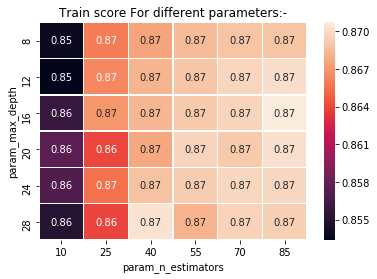

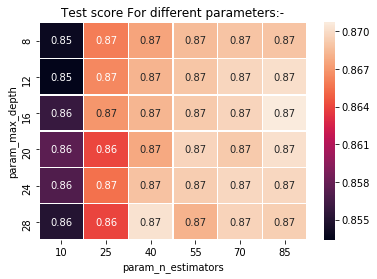

In [87]:
GridCvresult(GSC31)

AUC score on test set: 85.901%
Accuracy on test set: 77.047%
Precision on test set: 95.720
Recall on test set: 76.851
F1-Score on test set: 85.254


C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_roc_curve instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_roc_curve instead.
  warnings.warn(msg, category=DeprecationWarning)


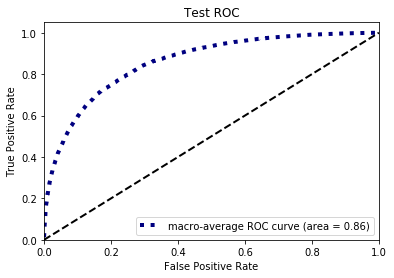

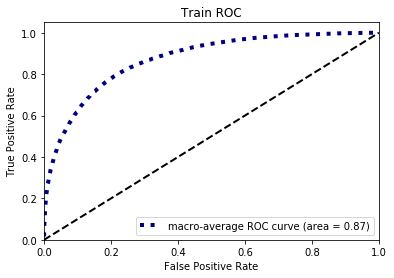

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<Figure size 432x288 with 0 Axes>

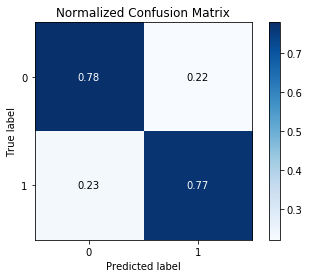

In [88]:
#performance of model on tuned hyperparamters with test data
clf31= Randomforest(max_depth,n_estimators,XtrainW2VV,XtestW2VV)

## GBDTClassifier

In [89]:
#gridsearchCv
max_depth,n_estimators,GSC32= GridCvGBDT(XtrainW2VV)


 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, criterion='gini', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
       n_estimators=85, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=0.125, seed=None, silent=True,
       subsample=0.2)
Best Hyperparameter is  {'max_depth': 8, 'n_estimators': 85}
Best auc score is  0.883984026309867


Showing Gridcv results


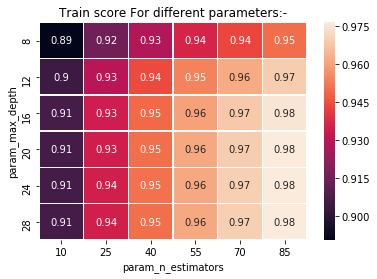

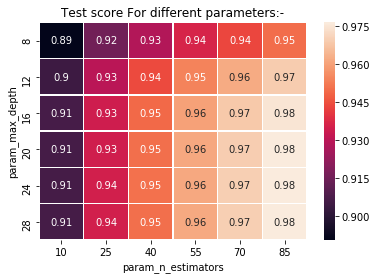

In [90]:
GridCvresult(GSC32)

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


AUC score on test set: 89.276%
Accuracy on test set: 83.323%
Precision on test set: 95.817
Recall on test set: 84.368
F1-Score on test set: 89.729


C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_roc_curve instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_roc_curve instead.
  warnings.warn(msg, category=DeprecationWarning)


<Figure size 432x288 with 0 Axes>

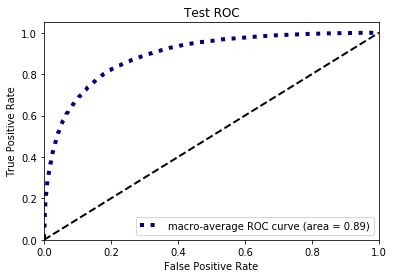

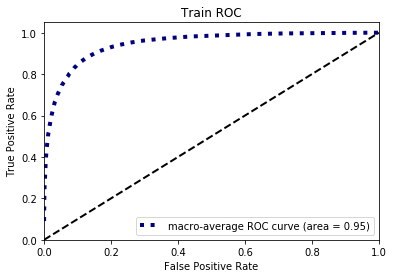

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<Figure size 432x288 with 0 Axes>

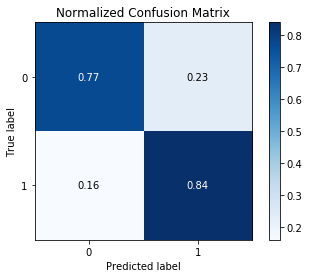

In [91]:
#performance of model on tuned hyperparamters with test data
clf32=GBDTclassif(max_depth,n_estimators,XtrainW2VV,XtestW2VV)

# TFIDF-weighted avg W2V vectorization-------------------------------------

In [92]:
tfmodel=TfidfVectorizer(max_features=2000)
tf_idf_matrix = tfmodel.fit_transform(Xtrain.values)
tfidf_feat=tfmodel.get_feature_names()
dictionary = {k:v for (k,v) in zip(tfmodel.get_feature_names(), list(tfmodel.idf_))}

In [93]:
def tfidfw2vVect(X):
    '''
    This function converts list of sentance into list of list of words and then 
    finally applies average-tfidf-w2w to get final sentance vector
    w2v model and w2v words already made during w2v vectorization part 
    '''
    lists=[]
    for sent in X.values:
        filtered_sentence=[]
        sent=cleanhtml(sent)
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if(cleaned_words.isalpha()):
                    filtered_sentence.append(cleaned_words.lower())
                else:
                    continue
        lists.append(filtered_sentence)
        
    tfidfw2v_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in lists: # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            try:
                if word in w2v_words:
                    vec = w2v_model.wv[word]
                    #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                    #to reduce the computation we are 
                    #dictionary[word] = idf value of word in whole courpus
                    #sent.count(word) = tf valeus of word in this review
                    tf_idf = (dictionary[word])*((sent.count(word))/len(sent))
                    sent_vec += (vec * tf_idf)
                    weight_sum += tf_idf
            except:
                pass
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidfw2v_sent_vectors.append(sent_vec)
        row += 1
    # converting nan and infinte values in vect to digit
    tfidfw2v_sent_vectors= np.nan_to_num(tfidfw2v_sent_vectors)
    return tfidfw2v_sent_vectors

In [94]:
# feeding text data and recieving vectorized data
XtrainTFIDFW2VV= tfidfw2vVect(Xtrain)
XtestTFIDFW2VV= tfidfw2vVect(Xtest)

In [95]:
#Standardizing vectors
std = StandardScaler(with_mean=False).fit(XtrainTFIDFW2VV)
XtrainTFIDFW2VV = std.transform(XtrainTFIDFW2VV)
XtestTFIDFW2VV = std.transform(XtestTFIDFW2VV)

## RamdomForest

In [96]:
#gridsearchCv
max_depth,n_estimators,GSC41= GridCvDt(XtrainTFIDFW2VV)


 RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=16, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=1500, min_weight_fraction_leaf=0.0,
            n_estimators=70, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Best Hyperparameter is  {'max_depth': 16, 'n_estimators': 70}
Best auc score is  0.8181580916215869


Showing Gridcv results


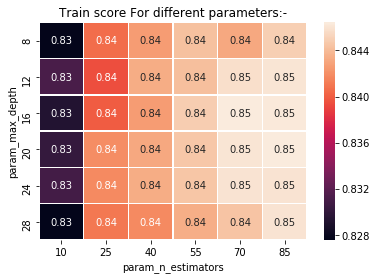

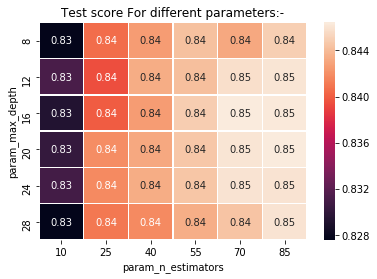

In [97]:
GridCvresult(GSC41)

AUC score on test set: 82.723%
Accuracy on test set: 75.630%
Precision on test set: 94.581
Recall on test set: 76.137
F1-Score on test set: 84.363


C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_roc_curve instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_roc_curve instead.
  warnings.warn(msg, category=DeprecationWarning)


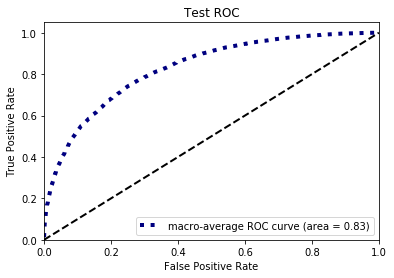

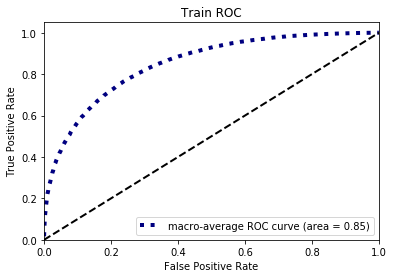

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<Figure size 432x288 with 0 Axes>

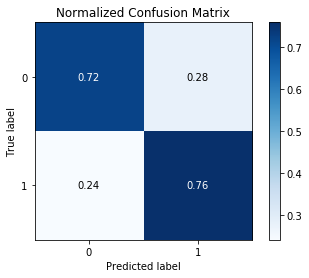

In [98]:
#performance of model on tuned hyperparamters with test data
clf41= Randomforest(max_depth,n_estimators,XtrainTFIDFW2VV,XtestTFIDFW2VV)

## GBDTClassifier

In [99]:
#gridsearchCv
max_depth,n_estimators,GSC42= GridCvGBDT(XtrainTFIDFW2VV)


 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, criterion='gini', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
       n_estimators=85, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=0.125, seed=None, silent=True,
       subsample=0.2)
Best Hyperparameter is  {'max_depth': 8, 'n_estimators': 85}
Best auc score is  0.8581880456308878


Showing Gridcv results


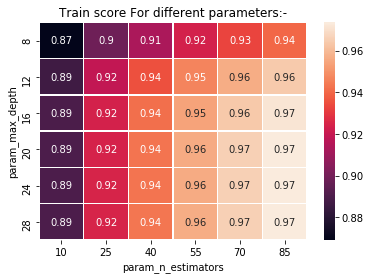

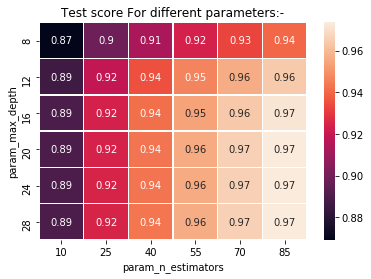

In [100]:
GridCvresult(GSC42)

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


AUC score on test set: 86.414%
Accuracy on test set: 81.180%
Precision on test set: 94.985
Recall on test set: 82.561
F1-Score on test set: 88.339


C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_roc_curve instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_roc_curve instead.
  warnings.warn(msg, category=DeprecationWarning)


<Figure size 432x288 with 0 Axes>

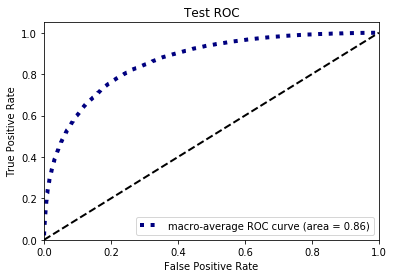

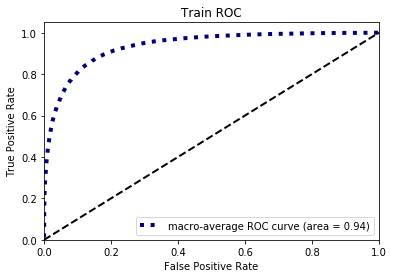

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<Figure size 432x288 with 0 Axes>

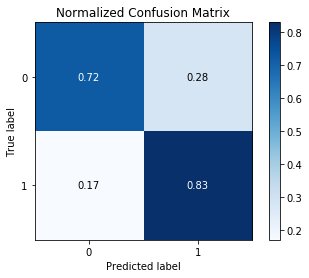

In [101]:
#performance of model on tuned hyperparamters with test data
clf42=GBDTclassif(max_depth,n_estimators,XtrainTFIDFW2VV,XtestTFIDFW2VV)


# ----------------------------------------------------------------------------------------------------
# <center>Summary</center>
## <center>RandomForest</center>
Vectorizer|Optimal max_Depth|Optimal n_estimators|AUC Score|Accuracy|Precision|Recall|F1 Score
---|---|---|---|---|---|---|---
BOW |28|85|90.944|84.747|96.535|85.399|90.626
TFIDF |28|85|90.725|84.770|96.298|85.654|90.664
W2V |16|85|85.901|77.047|95.720|76.851|85.254
TFIDF-W2v |16|70|82.723|75.630|94.581|76.137|84.363

## <center>GradientBoostDT</center>
Vectorizer|Optimal max_Depth|Optimal n_estimators|AUC Score|Accuracy|Precision|Recall|F1 Score
---|---|---|---|---|---|---|---
BOW |28|85|91.174|85.340|96.389|86.252|91.039
TFIDF |28|85|90.698|85.627|95.967|87.009|91.269
W2V |8|85|89.276|83.323|95.817|84.368|89.729
TFIDF-W2v |8|85|86.414|81.180|94.985|82.561|88.339

### Observations
* Best results were found using BOW with GradientBoostDT with auc score of 91.1%
* There is significant improvement in score from simple decisionTree model to GradientBoostDT and RandomForest  
* Time taken by ensemble models is more than normal models like logistic regression, DecisionTrees 
* In our case with given data, performance of GBDT was better than RandomForest in terms of roc_auc score

In [102]:
print('end\n\n\n\n\n')

end





